In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
! mkdir data
! unzip -q skin-cancer-mnist-ham10000.zip -d data



Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 59% 3.09G/5.20G [01:19<00:52, 42.8MB/s]

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, MaxPooling2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Layer
from itertools import product
from collections import defaultdict
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the metadata
METADATA_FILE = os.path.join('data', 'HAM10000_metadata.csv')
metadata = pd.read_csv(METADATA_FILE)

# Define the image directories
IMAGE_DIRS = [os.path.join('data', 'HAM10000_images_part_1'),
              os.path.join('data', 'HAM10000_images_part_2')]

# Function to get full image path
def get_image_path(image_id, dirs):
    for dir in dirs:
        image_path = os.path.join(dir, f'{image_id}.jpg')
        if os.path.exists(image_path):
            return image_path
    return None

# Add a column with the full image paths
metadata['image_path'] = metadata['image_id'].apply(lambda x: get_image_path(x, IMAGE_DIRS))

# Filter out any entries without a corresponding image
metadata = metadata.dropna(subset=['image_path'])

# Define the Soft Attention Layer
class SoftAttention(Layer):
    def __init__(self, ch, m, concat_with_x=False, aggregate=False, **kwargs):
        self.channels = int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x
        super(SoftAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.i_shape = input_shape
        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads)  # DHWC

        self.out_attention_maps_shape = input_shape[0:1] + (self.multiheads,) + input_shape[1:-1]

        if not self.aggregate_channels:
            self.out_features_shape = input_shape[:-1] + (input_shape[-1] + (input_shape[-1] * self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1] + (input_shape[-1] * 2,)
            else:
                self.out_features_shape = input_shape

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                             initializer='he_uniform',
                                             name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                           initializer='zeros',
                                           name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):
        exp_x = tf.expand_dims(x, axis=-1)

        c3d = tf.nn.conv3d(exp_x, filters=self.kernel_conv3d, strides=[1, 1, 1, self.i_shape[-1], 1], padding='SAME')
        conv3d = tf.nn.bias_add(c3d, self.bias_conv3d)
        conv3d = tf.nn.relu(conv3d)

        conv3d = tf.transpose(conv3d, perm=[0, 4, 1, 2, 3])

        conv3d = tf.squeeze(conv3d, axis=-1)
        conv3d = tf.reshape(conv3d, shape=(-1, self.multiheads, self.i_shape[1] * self.i_shape[2]))

        softmax_alpha = tf.nn.softmax(conv3d, axis=-1)
        softmax_alpha = tf.reshape(softmax_alpha, shape=(-1, self.multiheads, self.i_shape[1], self.i_shape[2]))

        if not self.aggregate_channels:
            exp_softmax_alpha = tf.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = tf.transpose(exp_softmax_alpha, perm=[0, 2, 3, 1, 4])

            x_exp = tf.expand_dims(x, axis=-2)
            u = tf.multiply(exp_softmax_alpha, x_exp)

            u = tf.reshape(u, shape=(-1, self.i_shape[1], self.i_shape[2], u.shape[-1] * u.shape[-2]))
        else:
            exp_softmax_alpha = tf.transpose(softmax_alpha, perm=[0, 2, 3, 1])
            exp_softmax_alpha = tf.reduce_sum(exp_softmax_alpha, axis=-1)
            exp_softmax_alpha = tf.expand_dims(exp_softmax_alpha, axis=-1)

            u = tf.multiply(exp_softmax_alpha, x)

        if self.concat_input_with_scaled:
            o = tf.concat([u, x], axis=-1)
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]

    def get_config(self):
        return super(SoftAttention, self).get_config()

def create_soft_attention_model(learning_rate=0.001, dropout_rate=0.5, attention_heads=16, optimizer_type='adam'):
    irv2 = tf.keras.applications.InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    # Exclude the last layers of the model
    conv = irv2.layers[-28].output

    # Apply the Soft Attention Layer
    attention_layer, map2 = SoftAttention(aggregate=True, m=attention_heads, concat_with_x=False, ch=int(conv.shape[-1]), name='soft_attention')(conv)

    # Add pooling and other layers
    attention_layer = MaxPooling2D(pool_size=(2, 2), padding="same")(attention_layer)
    conv = MaxPooling2D(pool_size=(2, 2), padding="same")(conv)

    conv = concatenate([conv, attention_layer])

    # Use original activation function
    conv = Activation('relu')(conv)

    conv = Dropout(dropout_rate)(conv)  # Apply dropout

    # Flatten the output
    output = Flatten()(conv)

    # The final layer should have 7 units (number of classes), with softmax activation for classification
    output = Dense(7, activation='softmax')(output)  # 7 classes in the dataset

    # Choose optimizer
    if optimizer_type == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=0.1)
    elif optimizer_type == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_type == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    # Compile the model
    model = Model(inputs=irv2.input, outputs=output)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


from itertools import product
from collections import defaultdict
import numpy as np

class stratifiedKFold:
    def __init__(self, n_split, shuffle=True, random_state=None):
        self.n_split = n_split
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y):
        if (self.shuffle and self.random_state) is not None:
            np.random.seed(self.random_state)

        idx = np.arange(len(y))
        if self.shuffle:
            np.random.shuffle(idx)

        y_idx = defaultdict(list)
        for i, label in zip(idx, y):
            y_idx[label].append(i)

        splits = [[] for _ in range(self.n_split)]

        for label, indices in y_idx.items():
            np.random.shuffle(indices)
            split_portions = [len(indices) // self.n_split] * self.n_split
            for j in range(len(indices) % self.n_split):
                split_portions[j] += 1

            first = 0
            for k in range(self.n_split):
                last = first + split_portions[k]
                splits[k].extend(indices[first:last])
                first = last

        for i in range(self.n_split):
            test_idx = splits[i]
            train_idx = np.concatenate([splits[j] for j in range(self.n_split) if j != i])
            yield train_idx, test_idx

    def get_n_splits(self):
        return self.n_split

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 1601 validated image filenames belonging to 7 classes.
Found 201 validated image filenames belonging to 7 classes.
Found 201 validated image filenames belonging to 7 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 289s 9s/step - accuracy: 0.1062 - loss: 1.9629 - val_accuracy: 0.2090 - val_loss: 1.9188
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1165 - loss: 1.9404 - val_accuracy: 0.3831 - val_loss: 1.8911
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2662 - loss: 1.9062 - val_accuracy: 0.6119 - val_loss: 1.8558
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5419 - loss: 1.8670 - val_accuracy: 0.6418 - val_loss: 1.8152
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6885 - loss: 1.8152 - val_accuracy: 0.6418 - val_loss: 1.7663
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 967ms/step - accuracy: 0.6736 - loss: 1.7664 - val_accuracy: 0.6418 - val_loss: 1.7076
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6794 - loss: 1.6967 - val_accuracy: 0.6418 - val_loss: 1.6366
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 951ms/step - accuracy: 0.6798 - loss: 1.6207 - val_accuracy: 0.6418 - val_loss: 1.5

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 245s 7s/step - accuracy: 0.1443 - loss: 1.9340 - val_accuracy: 0.2488 - val_loss: 1.9195
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 961ms/step - accuracy: 0.3193 - loss: 1.9044 - val_accuracy: 0.6169 - val_loss: 1.8796
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 950ms/step - accuracy: 0.5751 - loss: 1.8636 - val_accuracy: 0.6418 - val_loss: 1.8289
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 967ms/step - accuracy: 0.6754 - loss: 1.8095 - val_accuracy: 0.6418 - val_loss: 1.7683
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6757 - loss: 1.7454 - val_accuracy: 0.6418 - val_loss: 1.6950
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 955ms/step - accuracy: 0.6853 - loss: 1.6698 - val_accuracy: 0.6418 - val_loss: 1.6079
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6625 - loss: 1.5917 - val_accuracy: 0.6418 - val_loss: 1.5109
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6683 - loss: 1.4869 - val_accuracy: 0.6418 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 247s 7s/step - accuracy: 0.0612 - loss: 1.9781 - val_accuracy: 0.0547 - val_loss: 1.9730
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.0753 - loss: 1.9586 - val_accuracy: 0.0697 - val_loss: 1.9435
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2097 - loss: 1.9220 - val_accuracy: 0.3433 - val_loss: 1.9091
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 954ms/step - accuracy: 0.4493 - loss: 1.8863 - val_accuracy: 0.6269 - val_loss: 1.8698
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6328 - loss: 1.8432 - val_accuracy: 0.6418 - val_loss: 1.8239
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6780 - loss: 1.7961 - val_accuracy: 0.6418 - val_loss: 1.7685
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6751 - loss: 1.7417 - val_accuracy: 0.6418 - val_loss: 1.7034
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6608 - loss: 1.6769 - val_accuracy: 0.6418 - val_loss: 1.6246

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 244s 7s/step - accuracy: 0.1405 - loss: 1.9400 - val_accuracy: 0.2886 - val_loss: 1.9220
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 958ms/step - accuracy: 0.2952 - loss: 1.9132 - val_accuracy: 0.6070 - val_loss: 1.8856
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 949ms/step - accuracy: 0.5526 - loss: 1.8688 - val_accuracy: 0.6418 - val_loss: 1.8390
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6725 - loss: 1.8125 - val_accuracy: 0.6418 - val_loss: 1.7816
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6707 - loss: 1.7553 - val_accuracy: 0.6418 - val_loss: 1.7123
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6704 - loss: 1.6804 - val_accuracy: 0.6418 - val_loss: 1.6305
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 953ms/step - accuracy: 0.6918 - loss: 1.5799 - val_accuracy: 0.6418 - val_loss: 1.5373
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 959ms/step - accuracy: 0.6849 - loss: 1.4866 - val_accuracy: 0.6418 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 237s 7s/step - accuracy: 0.1255 - loss: 1.9404 - val_accuracy: 0.1393 - val_loss: 1.9546
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1333 - loss: 1.9401 - val_accuracy: 0.1692 - val_loss: 1.9500
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 958ms/step - accuracy: 0.1332 - loss: 1.9356 - val_accuracy: 0.1741 - val_loss: 1.9450
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1768 - loss: 1.9311 - val_accuracy: 0.1692 - val_loss: 1.9394
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1944 - loss: 1.9256 - val_accuracy: 0.1891 - val_loss: 1.9328
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2475 - loss: 1.9213 - val_accuracy: 0.2239 - val_loss: 1.9257
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2633 - loss: 1.9168 - val_accuracy: 0.2786 - val_loss: 1.9187
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3067 - loss: 1.9102 - val_accuracy: 0.3085 - val_loss: 1.9113

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.0869 - loss: 1.9643 - val_accuracy: 0.1692 - val_loss: 1.9385
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.0910 - loss: 1.9611 - val_accuracy: 0.1592 - val_loss: 1.9404
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 956ms/step - accuracy: 0.0986 - loss: 1.9589 - val_accuracy: 0.1393 - val_loss: 1.9431
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.0951 - loss: 1.9553 - val_accuracy: 0.1343 - val_loss: 1.9444
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1337 - loss: 1.9486 - val_accuracy: 0.1393 - val_loss: 1.9436
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1404 - loss: 1.9415 - val_accuracy: 0.1791 - val_loss: 1.9436
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1613 - loss: 1.9394 - val_accuracy: 0.1940 - val_loss: 1.9418
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2084 - loss: 1.9311 - val_accuracy: 0.1990 - val_loss: 1.9410

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 238s 7s/step - accuracy: 0.2304 - loss: 1.9197 - val_accuracy: 0.0896 - val_loss: 1.9365
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 961ms/step - accuracy: 0.2701 - loss: 1.9173 - val_accuracy: 0.1244 - val_loss: 1.9316
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 954ms/step - accuracy: 0.2921 - loss: 1.9113 - val_accuracy: 0.2090 - val_loss: 1.9265
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 954ms/step - accuracy: 0.3247 - loss: 1.9094 - val_accuracy: 0.3483 - val_loss: 1.9210
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3605 - loss: 1.9048 - val_accuracy: 0.3881 - val_loss: 1.9144
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4114 - loss: 1.8984 - val_accuracy: 0.4428 - val_loss: 1.9064
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4868 - loss: 1.8913 - val_accuracy: 0.5423 - val_loss: 1.8982
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4731 - loss: 1.8875 - val_accuracy: 0.5871 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 236s 7s/step - accuracy: 0.0932 - loss: 1.9747 - val_accuracy: 0.1393 - val_loss: 1.9890
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 960ms/step - accuracy: 0.0917 - loss: 1.9679 - val_accuracy: 0.1393 - val_loss: 1.9844
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 963ms/step - accuracy: 0.0987 - loss: 1.9670 - val_accuracy: 0.1244 - val_loss: 1.9802
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 955ms/step - accuracy: 0.1114 - loss: 1.9599 - val_accuracy: 0.1244 - val_loss: 1.9749
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 960ms/step - accuracy: 0.1109 - loss: 1.9547 - val_accuracy: 0.1244 - val_loss: 1.9704
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1189 - loss: 1.9528 - val_accuracy: 0.1343 - val_loss: 1.9656
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1544 - loss: 1.9414 - val_accuracy: 0.1343 - val_loss: 1.9594
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 955ms/step - accuracy: 0.1723 - loss: 1.9358 - val_accuracy: 0.1542 - val_

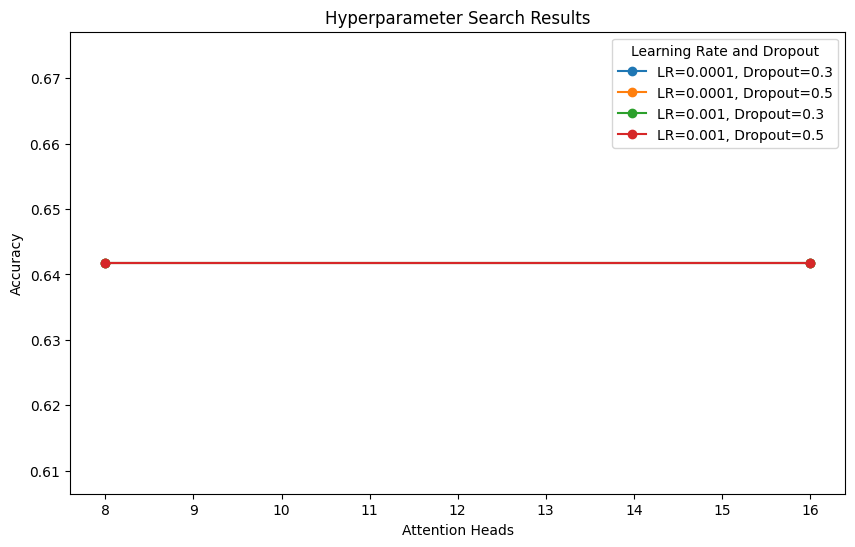

Best Hyperparameters: learning_rate      0.001000
dropout            0.300000
attention_heads    8.000000
accuracy           0.641791
Name: 0, dtype: float64


In [ ]:
def simple_cross_validate(metadata, hyperparameters, subset_fraction=0.2):
    # Use a subset of data (20% of the total dataset) for hyperparameter testing
    metadata_subset, _ = train_test_split(metadata, test_size=1-subset_fraction, random_state=42)

    # Split data into training (80%), validation (10%), and test (10%) from the subset
    train_val_split, test_split = train_test_split(metadata_subset, test_size=0.1, random_state=42)
    train_split, val_split = train_test_split(train_val_split, test_size=0.1111, random_state=42)  # 10% of 90%

    result_data = []

    param_keys = [list(d.keys())[0] for d in hyperparameters]
    param_values = [list(d.values())[0] for d in hyperparameters]
    combinations = product(*param_values)
    hyper_combo = [{param_keys[i]: combo[i] for i in range(len(param_keys))} for combo in combinations]

    # Test each hyperparameter combination
    for param in hyper_combo:
        model = create_soft_attention_model(
            learning_rate=param['lr'],
            dropout_rate=param['dropout'],
            attention_heads=param['attention_heads']
        )

        EPOCHS = 30  # Fixed epochs

        train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
        val_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)

        BATCH_SIZE = 128  # Batch size set to 128

        # Train generator
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_split,
            x_col='image_path',
            y_col='dx',
            target_size=(224, 224),
            batch_size=BATCH_SIZE,
            class_mode='categorical'
        )

        # Validation generator
        val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_split,
            x_col='image_path',
            y_col='dx',
            target_size=(224, 224),
            batch_size=BATCH_SIZE,
            class_mode='categorical'
        )

        # Test generator
        test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_split,
            x_col='image_path',
            y_col='dx',
            target_size=(224, 224),
            batch_size=BATCH_SIZE,
            class_mode='categorical'
        )

        # Train the model
        history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, verbose=1)

        val_acc = max(history.history['val_accuracy'])

        # Append the hyperparameters and their corresponding accuracy
        result_data.append({
            'learning_rate': param['lr'],
            'dropout': param['dropout'],
            'attention_heads': param['attention_heads'],
            'accuracy': val_acc
        })

    # Convert the results to a DataFrame for visualization
    results_df = pd.DataFrame(result_data)

    return results_df

# Define the hyperparameters to test
hypers = [
    {'lr': [0.001, 0.0001]},  # Learning rates
    {'dropout': [0.3, 0.5]},  # Dropout rates
    {'attention_heads': [8, 16]}  # Number of attention heads to avoid memory issues
]

# Testing the hyperparameters with the metadata DataFrame
results_df = simple_cross_validate(metadata, hypers)

# Display the DataFrame
print(results_df)

# Plot the hyperparameter results
plt.figure(figsize=(10,6))
for key, grp in results_df.groupby(['learning_rate', 'dropout']):
    plt.plot(grp['attention_heads'], grp['accuracy'], marker='o', label=f'LR={key[0]}, Dropout={key[1]}')

plt.title('Hyperparameter Search Results')
plt.xlabel('Attention Heads')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate and Dropout')
plt.show()

# Get the best hyperparameters based on accuracy
best_params = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best Hyperparameters: {best_params}")



In [ ]:
from keras.callbacks import ModelCheckpoint

def train_with_20_fold_cross_validation_and_save(metadata, best_hyperparams, model_save_path):
    # Set up 20-fold cross-validation
    kfold = stratifiedKFold(n_split=20, shuffle=True, random_state=42)
    fold_accuracies = []

    param_lr = best_hyperparams['learning_rate']
    param_dropout = best_hyperparams['dropout']
    param_attention_heads = best_hyperparams['attention_heads']

    # Loop over each fold
    for fold, (train_idx, val_idx) in enumerate(kfold.split(metadata, metadata['dx'])):
        print(f"\nTraining fold {fold + 1}/20...")

        # Split data into training and validation for this fold
        train_split = metadata.iloc[train_idx]
        val_split = metadata.iloc[val_idx]

        # Create the model with the best hyperparameters
        model = create_soft_attention_model(
            learning_rate=param_lr,
            dropout_rate=param_dropout,
            attention_heads=param_attention_heads
        )

        EPOCHS = 30  # You can adjust this based on your needs

        train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
        val_datagen = ImageDataGenerator(rescale=1./255)

        BATCH_SIZE = 128  # Keep batch size optimized for your T4 GPU

        # Train generator
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_split,
            x_col='image_path',
            y_col='dx',
            target_size=(224, 224),
            batch_size=BATCH_SIZE,
            class_mode='categorical'
        )

        # Validation generator
        val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_split,
            x_col='image_path',
            y_col='dx',
            target_size=(224, 224),
            batch_size=BATCH_SIZE,
            class_mode='categorical'
        )

        # Set up model checkpoint to save the model when validation accuracy improves
        checkpoint = ModelCheckpoint(
            filepath=f"{model_save_path}_fold_{fold + 1}.h5",  # Save model for each fold
            monitor='val_accuracy',  # Track validation accuracy
            save_best_only=True,     # Only save the model if it improves
            mode='max',
            verbose=1
        )

        # Train the model on this fold
        history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, verbose=1, callbacks=[checkpoint])

        # Get the validation accuracy for this fold
        val_acc = max(history.history['val_accuracy'])
        fold_accuracies.append(val_acc)

        print(f"Validation Accuracy for fold {fold + 1}: {val_acc:.4f}")

    # Calculate and print the average accuracy across all folds
    avg_accuracy = np.mean(fold_accuracies)
    print(f"\nAverage Validation Accuracy across 20 folds: {avg_accuracy:.4f}")

    return avg_accuracy

# Now, train using the best hyperparameters found earlier
best_hyperparams = {
    'learning_rate': 0.001,
    'dropout': 0.3,
    'attention_heads': 8
}


# Define the model save path
model_save_path = 'soft_attention_model'

# Train the model with 20-fold cross-validation and save the best model for each fold
average_accuracy = train_with_20_fold_cross_validation_and_save(metadata, best_hyperparams, model_save_path)
